In [4]:
import torch
import time
from torch import nn
from torch.nn import functional as F

In [3]:
import utils as prologue

train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = True, normalize = True, flatten = False)

* Using MNIST



Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [5]:
class Net(nn.Module):
    def __init__(self, hidden_units=200):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [6]:
def train_model(model, train_input, train_target, mini_batch_size=100, verbose=False):

    acc_loss = 0

    for b in range(0, train_input.size(0), mini_batch_size):
        output = model(train_input.narrow(0, b, mini_batch_size))
        loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()

        # Reset model gradient to zero after training on all samples
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= eta * p.grad
    
    if verbose:
        print(f"Epoch {e}, loss {acc_loss}")
    
    return acc_loss

In [7]:
def compute_nb_errors(model, input, target, mini_batch_size, verbose=False):

    nb_errors = 0
    
    for b in range(0, input.size(0), mini_batch_size):
        
        output = model(input.narrow(0, b, mini_batch_size))
        
        prediction = output.argmax(1)
        
        nb_errors += (mini_batch_size - \
                      target.narrow(0, b, mini_batch_size)[range(0, mini_batch_size), prediction].sum())
    
    if verbose:
        print(f"Number of errors: {nb_errors} on {input.size(0)}")
    
    return float(nb_errors) / input.size(0)

In [8]:
collected_data = {
    10: { 'time': 0.0, 'loss': [], 'error': [] },
    50: { 'time': 0.0, 'loss': [], 'error': [] },
    200: { 'time': 0.0, 'loss': [], 'error': [] },
    500: { 'time': 0.0, 'loss': [], 'error': [] },
    1000: { 'time': 0.0, 'loss': [], 'error': [] },
}

for hidden_units in [10, 50, 200, 500, 1000]:
    
    start = time.perf_counter()
    
    model, criterion = Net(hidden_units), nn.MSELoss()
    eta = 1e-1
    nb_epochs = 25

    for e in range(nb_epochs):
        loss = train_model(model, train_input, train_target, 100, e % 5 == 0)
        err = compute_nb_errors(model, test_input, test_target, 100, e % 5 == 0)
        
        collected_data[hidden_units]['loss'].append(loss)
        collected_data[hidden_units]['error'].append(err)
        
    duration = time.perf_counter() - start
    collected_data[hidden_units]['time'] = duration

Epoch 0, loss 1.3564119338989258
Number of errors: 882.0 on 1000
Epoch 5, loss 0.7927895411849022
Number of errors: 625.0 on 1000
Epoch 10, loss 0.7249075174331665
Number of errors: 521.0 on 1000
Epoch 15, loss 0.7090759053826332
Number of errors: 562.0 on 1000
Epoch 20, loss 0.6665126532316208
Number of errors: 461.0 on 1000
Epoch 0, loss 0.9606640934944153
Number of errors: 715.0 on 1000
Epoch 5, loss 0.5927225425839424
Number of errors: 382.0 on 1000
Epoch 10, loss 0.4631996937096119
Number of errors: 223.0 on 1000
Epoch 15, loss 0.38536905869841576
Number of errors: 186.0 on 1000
Epoch 20, loss 0.3457621093839407
Number of errors: 185.0 on 1000
Epoch 0, loss 0.9365581199526787
Number of errors: 713.0 on 1000
Epoch 5, loss 0.5666293390095234
Number of errors: 351.0 on 1000
Epoch 10, loss 0.415267962962389
Number of errors: 228.0 on 1000
Epoch 15, loss 0.3560158759355545
Number of errors: 148.0 on 1000
Epoch 20, loss 0.3003829959779978
Number of errors: 187.0 on 1000
Epoch 0, loss 0.

In [10]:
import json 

with open('./practical-4-results.json', 'w') as fp:
    json.dump(collected_data, fp)

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
df = pd.read_json('./results.json').transpose()

In [19]:
df.head()

,time,loss,error
10,20.1668,"[1.356411933898925, 0.9835229218006131, 0.8677...","[0.882, 0.798, 0.734, 0.6900000000000001, 0.65..."
50,19.4351,"[0.9606640934944151, 0.7952605411410331, 0.726...","[0.715, 0.56, 0.486, 0.396, 0.341, 0.382, 0.43..."
200,19.6689,"[0.9365581199526781, 0.796606212854385, 0.7205...","[0.713, 0.47300000000000003, 0.394, 0.373, 0.3..."
500,20.1064,"[0.8907997980713841, 0.774697534739971, 0.6967...","[0.686, 0.489, 0.435, 0.40700000000000003, 0.3..."
1000,22.3928,"[0.900763005018234, 0.747681371867656, 0.66380...","[0.642, 0.527, 0.465, 0.404, 0.333, 0.323, 0.2..."


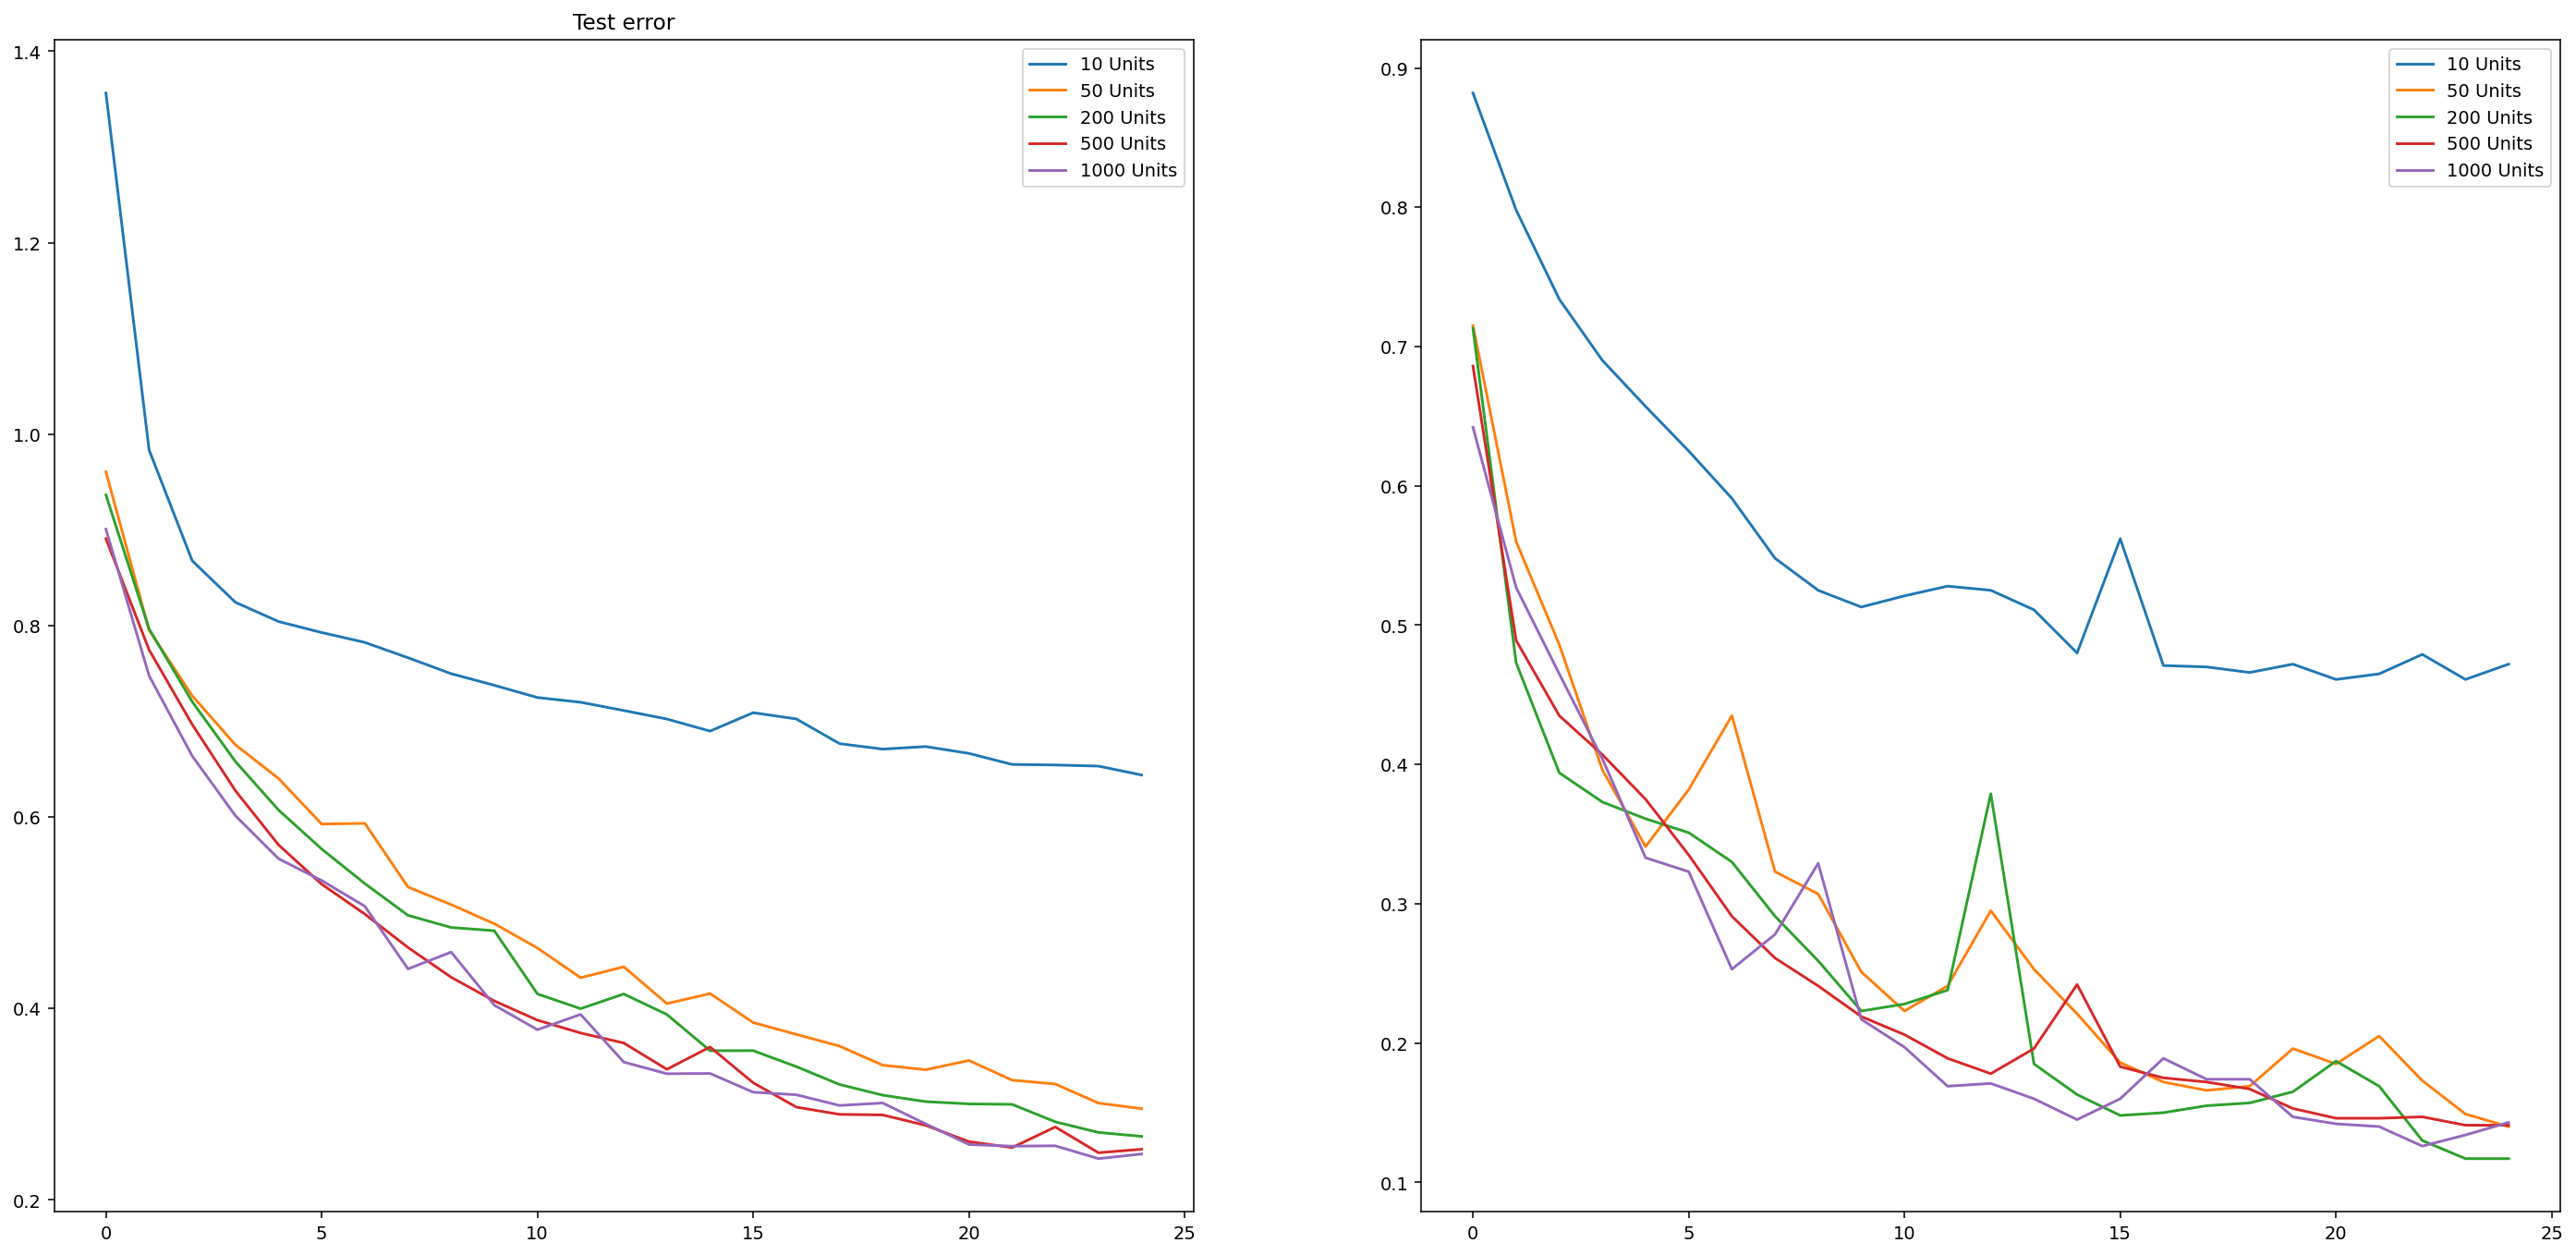

In [40]:
fig, axes = plt.subplots(1,2, figsize=(25, 12), dpi=140)

axes[0].set_title("Loss")
sns.lineplot(x=list(range(0, 25)), y=df.loc[10].loss, label="10 Units", ax=axes[0])
sns.lineplot(x=list(range(0, 25)), y=df.loc[50].loss, label="50 Units", ax=axes[0])
sns.lineplot(x=list(range(0, 25)), y=df.loc[200].loss, label="200 Units", ax=axes[0])
sns.lineplot(x=list(range(0, 25)), y=df.loc[500].loss, label="500 Units", ax=axes[0])
sns.lineplot(x=list(range(0, 25)), y=df.loc[1000].loss, label="1000 Units", ax=axes[0])

axes[0].set_title("Test error")
sns.lineplot(x=list(range(0, 25)), y=df.loc[10].error, label="10 Units", ax=axes[1])
sns.lineplot(x=list(range(0, 25)), y=df.loc[50].error, label="50 Units", ax=axes[1])
sns.lineplot(x=list(range(0, 25)), y=df.loc[200].error, label="200 Units", ax=axes[1])
sns.lineplot(x=list(range(0, 25)), y=df.loc[500].error, label="500 Units", ax=axes[1])
sns.lineplot(x=list(range(0, 25)), y=df.loc[1000].error, label="1000 Units", ax=axes[1])